# How Reliable is MT Evaluation?

In [ ]:
!pip install transformers torch
!pip install sentencepiece
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 2.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import collections
import math
import requests
from bs4 import BeautifulSoup
import tarfile
from urllib.parse import urljoin
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast, MarianMTModel, MarianTokenizer
import subprocess
import sentencepiece as spm
from tqdm import tqdm
import os
import pandas as pd
import shutil
import re
import torch
from glob import glob
import sacrebleu
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

# Check if a GPU is available, otherwise use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

## Re-evaluating the role of Bleu in machine translation research

Implementing the Bleu metric from scratch

In [ ]:
def ngrams(tokens, n):
    """
    Generate n-grams from a list of tokens.

    Args:
    tokens (list): List of tokens from which n-grams are generated.
    n (int): The 'n' in n-grams, specifying the length of each n-gram.

    Returns:
    list: A list of n-grams represented as tuples.
    """
    ngram_list = []  # Initialize an empty list to store n-grams.
    for i in range(len(tokens) - n + 1):
        # Iterate through the list of tokens, considering sequences of length 'n'.
        ngram_list.append(tuple(tokens[i:i + n]))  # Append the n-gram as a tuple to the list.
    return ngram_list  # Return the list of generated n-grams.


def tokenize_sentences(candidate, references, tokenization="words"):
    """
    Tokenize sentences based on the specified tokenization method.
    Args:
    candidate (str): The candidate sentence for translation.
    references (list): A list of reference sentences.
    tokenization (str): The tokenization method. Options: "words," "subwords," or "characters."
    Returns:
    tuple: A tuple containing the tokenized reference sentences (list) and tokenized candidate sentence (str).
    """
    if tokenization == "words":
        # Tokenize sentences into lowercase words.
        references = [[word.lower() for word in ref[0].split()] for ref in references]
        candidate = [word.lower() for word in candidate[0].split()]
    elif tokenization == "subwords":
        # Tokenize using a subword tokenizer (here: BERT AutoTokenizer).
        references = [tokenizer.tokenize(sentence) for sentence in references]
        candidate = tokenizer.tokenize(candidate)
    elif tokenization == "characters":
        # Tokenize sentences into individual characters.
        references = [[char for word in ref[0] for char in word] for ref in references]
        candidate = [char for word in candidate[0] for char in word]
    return references, candidate  # Return the tokenized reference sentences and candidate sentence.


def calculate_precision(candidate, references, n, tokenization="words"):
    """
    Calculate precision for n-grams between candidate and reference sentences.
    """
    references, candidate = tokenize_sentences(candidate, references)
    # Generate n-grams for the candidate sentence
    candidate_ngrams = ngrams(candidate, n)
    # Generate n-grams for each reference sentence
    reference_ngrams = [ngrams(ref, n) for ref in references]
    # Count the occurrences of each candidate n-gram
    candidate_ngram_counts = collections.Counter(candidate_ngrams)
    max_reference_ngram_counts = {} # dictionary to store maximum reference n-gram counts
    # Loop through reference n-grams to find maximum counts for each n-gram
    for ref_ngrams in reference_ngrams:
        ref_ngram_counts = collections.Counter(ref_ngrams)
        for ngram in ref_ngram_counts:
            max_reference_ngram_counts[ngram] = max(max_reference_ngram_counts.get(ngram, 0), ref_ngram_counts[ngram])

    # Calculate clipped counts (minimum of candidate and reference n-gram counts)
    clipped_counts = {ngram: min(candidate_ngram_counts[ngram], max_reference_ngram_counts.get(ngram, 0)) for ngram in candidate_ngrams}

    # Calculate precision as the sum of clipped counts divided by the maximum of the sum of candidate n-gram counts or 1
    precision = sum(clipped_counts.values()) / max(sum(candidate_ngram_counts.values()), 1)
    return precision

def calculate_bleu(candidate, references, max_n=4, tokenization="words"):
    """
    Calculate BLEU score for a candidate sentence with multiple references,
    to evaluate the quality of machine translations.
    candidate: machine-generated translation
    references: one or more human-generated translations
    max_n: the maximum n-gram order to consider (default is 4 for up to 4-grams)
    """
    precisions = [] # List to store individual n-gram precision scores for different values of 'n'

    # Calculate precision for different n-gram orders (typically 1 to 4)
    for n in range(1, max_n + 1):
        precision = calculate_precision(candidate, references, n, tokenization)

        # Append precision to the list if it's greater than 0 (non-zero precision)
        if precision > 0:
            precisions.append(precision)

    # Calculate the geometric mean of the individual precision scores
    geometric_mean = math.exp(sum(map(math.log, precisions)) / max_n)

    candidate_length = len(candidate)
    reference_lengths = [len(ref) for ref in references]

    # Find the length of the closest reference to the candidate
    closest_ref_length = min(reference_lengths, key=lambda ref_len: abs(candidate_length - ref_len))

    # Calculate brevity penalty, which is 1 if candidate length is greater, or a penalty based on length ratio if smaller
    if candidate_length > closest_ref_length:
        brevity_penalty = 1
    else:
        brevity_penalty = math.exp(1 - closest_ref_length / candidate_length)

    # Calculate the final BLEU score by combining brevity penalty and geometric mean of precisions
    bleu = brevity_penalty * geometric_mean
    return bleu

# Sample reference and candidate sentences
# references = [["the cat is on the mat"], ["there is a cat on the mat"]]
references = [["The little cat black sleeps under the blanket"]]
candidate = ["The big cat black sleeps under the blanket"]

# Calculate BLEU score
bleu_score = calculate_bleu(candidate, references)
print("BLEU Score:", bleu_score)

BLEU Score: 0.7071067811865475


Bleu places no explicit constraints on the order that matching n-grams
occur in. It is therefore possible, given a sentence, to generate many new sentences with at least as many n-gram matches by permuting words around bigram mismatches. Explain on an example why such permutations will never decrease the Bleu score.

In [ ]:
# Define the reference sentences
reference_sentences = ["The little black cat sleeps under the cozy blanket"]

# Define the candidate sentences (permutations)
candidate_sentences = [
    "The little cat black sleeps under the blanket",
    "The cat little black sleeps under the blanket",
    "The black little cat sleeps under the blanket",
    "The cat sleeps little black under the blanket",
    "The black cat little sleeps under the blanket",
    "The cat sleeps black little under the blanket",
    "The cozy little black cat sleeps under the blanket",
]

# Calculate and print BLEU scores for each candidate sentence
for i, candidate in enumerate(candidate_sentences):
    bleu_score = calculate_bleu(candidate, reference_sentences, max_n=4, tokenization="words")
    print(f"Permutation {i + 1}: BLEU Score = {bleu_score}")

Permutation 1: BLEU Score = 0.8948393168143697
Permutation 2: BLEU Score = 0.8948393168143697
Permutation 3: BLEU Score = 0.8948393168143697
Permutation 4: BLEU Score = 0.8948393168143697
Permutation 5: BLEU Score = 0.8948393168143697
Permutation 6: BLEU Score = 0.8948393168143697
Permutation 7: BLEU Score = 1.0


Using the WMT’15 test sets, evaluate the performance of mBart and MarianMT. These two models can be easily used with the HuggingFace API.

In [ ]:
## Using the WMT’15 test sets, evaluate the performance of mBart and MarianMT. These two models can be easily used with the HuggingFace API.
# 1. Acquire the test sets
# Define the URL of the web page
url = "https://statmt.org/wmt15/translation-task.html"
# Send an HTTP GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content of the web page
    soup = BeautifulSoup(response.content, "html.parser")

    # Find the download link by inspecting the HTML structure
    # Adjust the HTML element and attributes based on the actual page structure
    download_link = soup.find("a", text="Test sets (source and reference)")

    # Extract the URL of the download link
    if download_link:
        # Get the relative download URL
        relative_download_url = download_link.get("href")
        # Use urljoin to create a complete URL
        download_url = urljoin(url, relative_download_url)
        print("Download URL:", download_url)
        # Define the local file name to save the downloaded file
        local_filename = "/content/drive/MyDrive/Multilingual_NLP/Lab_3/test_sets.tgz"
        # Download the file using the obtained URL
        response = requests.get(download_url)

        # Check if the download was successful (status code 200)
        if response.status_code == 200:
            # Save the downloaded file to the local file system
            with open(local_filename, "wb") as file:
                file.write(response.content)
            # Extract the contents of the archive (if it's a compressed file)
            with tarfile.open(local_filename, "r:gz") as tar:
                tar.extractall("/content/drive/MyDrive/Multilingual_NLP/Lab_3/")

            print("Test sets downloaded and extracted successfully.")
        else:
            print("Failed to download the file.")
    else:
        print("Download link not found on the web page.")
else:
    print("Failed to access the web page.")


<ipython-input-4-cef2523cf790>:15: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  download_link = soup.find("a", text="Test sets (source and reference)")


Download URL: https://statmt.org/wmt15/test.tgz
Test sets downloaded and extracted successfully.


In [ ]:
# 2. Translate using mBART and MarianMT and save the model outputs to files
# Load the mBART model and tokenizer
model_mbart = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer_mbart = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
model_mbart = model_mbart.to(device)
# tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

In [ ]:
# Directory containing the input .sgm files
input_directory = "/content/drive/MyDrive/Multilingual_NLP/Lab_3/test/"

# Define a lambda function to collect all .sgm files in the input directory
get_input_files = lambda: glob.glob(f"{input_directory}/*.sgm")

# Get a list of input .sgm files using the lambda function
input_files = get_input_files()

In [ ]:
# Define the directory containing input files
input_directory = "/content/drive/MyDrive/Multilingual_NLP/Lab_3/test/"
# Get a list of all files in the directory
input_files = os.listdir(input_directory)
df = pd.DataFrame({"File name": input_files})

langs = []
lang_types = []
pairs = []
for file_name in input_files:
  lang = file_name.split("-")[-1].split(".")[1]
  langs.append(lang)
  lang_type = file_name.split("-")[-1].split(".")[0]
  lang_types.append(lang_type)
  lang_pair = file_name.split("-")[1]
  pairs.append(lang_pair)
df["lang"] = langs
df["type"] = lang_types
df["pair"] = pairs
df.sort_values(by="lang")

,File name,lang,type,pair
14,newstest2015-encs-ref.cs.sgm,cs,ref,encs
15,newstest2015-csen-src.cs.sgm,cs,src,csen
5,newstest2015-ende-ref.de.sgm,de,ref,ende
10,newstest2015-deen-src.de.sgm,de,src,deen
1,newstest2015-encs-src.en.sgm,en,src,encs
17,newstest2015-deen-ref.en.sgm,en,ref,deen
3,newstest2015-ruen-ref.en.sgm,en,ref,ruen
4,newsdiscusstest2015-enfr-src.en.sgm,en,src,enfr
6,newstest2015-fien-ref.en.sgm,en,ref,fien
8,newsdiscusstest2015-fren-ref.en.sgm,en,ref,fren


In [ ]:
df.sort_values(by="type")

,File name,lang,type,pair
9,newsdiscusstest2015-enfr-ref.fr.sgm,fr,ref,enfr
17,newstest2015-deen-ref.en.sgm,en,ref,deen
2,newstest2015-enru-ref.ru.sgm,ru,ref,enru
3,newstest2015-ruen-ref.en.sgm,en,ref,ruen
5,newstest2015-ende-ref.de.sgm,de,ref,ende
6,newstest2015-fien-ref.en.sgm,en,ref,fien
7,newstest2015-enfi-ref.fi.sgm,fi,ref,enfi
8,newsdiscusstest2015-fren-ref.en.sgm,en,ref,fren
18,newstest2015-csen-ref.en.sgm,en,ref,csen
14,newstest2015-encs-ref.cs.sgm,cs,ref,encs


In [ ]:
df["lang"].unique()

array(['en', 'ru', 'de', 'fi', 'fr', 'cs'], dtype=object)

In [ ]:
# Translating...
# Calculate the number of translations to do (files with "src" in their names)
nb_translations = sum(1 for input_file_name in input_files if "src" in input_file_name)

with tqdm(total=nb_translations, desc="Translating") as pbar:
    for input_file_name in input_files:
        # Preprocess the file
        with open(f"/content/drive/MyDrive/Multilingual_NLP/Lab_3/test/{input_file_name}", 'r') as sentences_file:
            content = sentences_file.read()
        sentences = re.findall(r'<seg id="\d+">(.*?)</seg>', content)

        # Split the files into source and reference files
        if "ref" in input_file_name:
            # This file contains a reference translation, so add it to the reference directory
            with open(f"/content/drive/MyDrive/Multilingual_NLP/Lab_3/reference_translations/{input_file_name.replace('sgm', 'txt')}", "w", encoding='utf-8') as ref_file:
                ref_file.write("\n".join(sentences))
            print(f"\nFile {input_file_name} added to reference translations\n")
        elif "src" in input_file_name:
            # Determine the language from the file's name
            lang_pair = input_file_name.split("-")[1]
            src_lang = lang_pair[:2]
            tgt_lang = lang_pair[2:]

            # Initialize the correct source language for mBart tokenizer
            tokenizer_mbart.src_lang = f"{src_lang}_XX"
            tokenizer_mbart.tgt_lang = f"{tgt_lang}_XX"

            # Download the correct MarianMT models depending on the language pair
            model_marian = MarianMTModel.from_pretrained(f"Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}")
            tokenizer_marian = MarianTokenizer.from_pretrained(f"Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}")
            model_marian = model_marian.to(device)

            # This file contains source text, so translate it
            print(f"\nProcessing the language pair {lang_pair.upper()}")
            print(f"Translating from {src_lang} to {tgt_lang}")

            # Group sentences for translation with both models
            batch_size = 10
            sentences_batches = [sentences[i:i + batch_size] for i in range(0, len(sentences), batch_size)]

            # Initialize lists to store translation outputs
            mbart_outputs = []
            marianmt_outputs = []

            # Translate each batch of sentences
            for batch in sentences_batches:
                # Tokenize the batch of sentences
                mbart_inputs = tokenizer_mbart.batch_encode_plus(batch, return_tensors="pt", padding=True, truncation=True)
                mbart_inputs = {key: value.to(device) for key, value in mbart_inputs.items()}
                marianmt_inputs = tokenizer_marian.batch_encode_plus(batch, return_tensors="pt", padding=True, truncation=True)
                marianmt_inputs = {key: value.to(device) for key, value in marianmt_inputs.items()}

                # Translate with mBart
                mbart_outputs_batch = model_mbart.generate(mbart_inputs["input_ids"], num_beams=4, early_stopping=True)
                mbart_outputs.extend([tokenizer_mbart.decode(output, skip_special_tokens=True) for output in mbart_outputs_batch])

                # Translate with MarianMT
                marianmt_outputs_batch = model_marian.generate(marianmt_inputs["input_ids"], num_beams=4, early_stopping=True)
                marianmt_outputs.extend([tokenizer_marian.decode(output, skip_special_tokens=True) for output in marianmt_outputs_batch])

                # Directly save the translated text into files
                output_file_mbart = f"/content/drive/MyDrive/Multilingual_NLP/Lab_3/mbart_translations/{input_file_name.replace('src', 'translated').replace('sgm', 'txt')}"
                output_file_marianmt = f"/content/drive/MyDrive/Multilingual_NLP/Lab_3/marianmt_translations/{input_file_name.replace('src', 'translated').replace('sgm', 'txt')}"
                with open(output_file_mbart, "a", encoding="utf-8") as file:
                    file.write("\n".join(mbart_outputs))
                with open(output_file_marianmt, "a", encoding="utf-8") as file:
                    file.write("\n".join(marianmt_outputs))

            pbar.update(1)

In [ ]:
# Load the data for reference translations
ref_directory = "/content/drive/MyDrive/Multilingual_NLP/Lab_3/reference_translations/"
input_files_ref = os.listdir(ref_directory)
df_ref = pd.DataFrame()

langs = []
lang_types = []
pairs = []
for file_name in input_files_ref:
    lang = file_name.split("-")[-1].split(".")[1]
    langs.append(lang)
    lang_type = file_name.split("-")[-1].split(".")[0]
    lang_types.append(lang_type)
    lang_pair = file_name.split("-")[1]
    pairs.append(lang_pair)
df_ref["Pair"] = pairs
df_ref["Ref file name"] = input_files_ref
df_ref["ref lang"] = langs
# df_ref["ref type"] = lang_types

# Load the data for mBart translations
mbart_directory = "/content/drive/MyDrive/Multilingual_NLP/Lab_3/mbart_translations/"
input_files_mbart = os.listdir(mbart_directory)
df_mbart = pd.DataFrame({"File name": input_files_mbart})

langs = []
lang_types = []
pairs = []
for file_name in input_files_mbart:
    lang = file_name.split("-")[-1].split(".")[1]
    langs.append(lang)
    lang_type = file_name.split("-")[-1].split(".")[0]
    lang_types.append(lang_type)
    lang_pair = file_name.split("-")[1]
    pairs.append(lang_pair)
df_mbart["lang"] = langs
df_mbart["type"] = lang_types
df_mbart["pair"] = pairs

# Load the data for marianMT translations
marian_directory = "/content/drive/MyDrive/Multilingual_NLP/Lab_3/marianmt_translations/"
input_files_marian = os.listdir(marian_directory)
df_marian = pd.DataFrame({"File name": input_files_marian})

langs = []
lang_types = []
pairs = []
for file_name in input_files_marian:
    lang = file_name.split("-")[-1].split(".")[1]
    langs.append(lang)
    lang_type = file_name.split("-")[-1].split(".")[0]
    lang_types.append(lang_type)
    lang_pair = file_name.split("-")[1]
    pairs.append(lang_pair)
df_marian["lang"] = langs
df_marian["type"] = lang_types
df_marian["pair"] = pairs

# Iterate over the rows in the reference DataFrame
for index, row in df_ref.iterrows():
    pair_code = row["Pair"]

    # Find the corresponding row in the DataFrames based on the pair code
    matching_row_mbart = df_mbart[df_mbart["pair"] == pair_code]
    matching_row_marian = df_marian[df_marian["pair"] == pair_code]

    # Extract the information you want from the matching row in the mBart DataFrame
    if not matching_row_mbart.empty:
        # For example, add the "File name" from the mBart DataFrame to the reference DataFrame
        df_ref.at[index, "mBart File Name"] = matching_row_mbart.iloc[0]["File name"]
        df_ref.at[index, "trad lang"] = matching_row_mbart.iloc[0]["lang"]
        # df_ref.at[index, "mBart type"] = matching_row_mbart.iloc[0]["type"]

    if not matching_row_marian.empty:
        # For example, add the "File name" from the mBart DataFrame to the reference DataFrame
        df_ref.at[index, "MarianMT File Name"] = matching_row_marian.iloc[0]["File name"]
        # df_ref.at[index, "MarianMT lang"] = matching_row_marian.iloc[0]["lang"]
        # df_ref.at[index, "MarianMT type"] = matching_row_marian.iloc[0]["type"]

# Display the resulting DataFrame with added columns
df_ref

,Pair,Ref file name,ref lang,mBart File Name,trad lang,MarianMT File Name
0,enru,newstest2015-enru-ref.ru.txt,ru,newstest2015-enru-translated.en.txt,en,newstest2015-enru-translated.en.txt
1,ruen,newstest2015-ruen-ref.en.txt,en,newstest2015-ruen-translated.ru.txt,ru,newstest2015-ruen-translated.ru.txt
2,ende,newstest2015-ende-ref.de.txt,de,newstest2015-ende-translated.en.txt,en,newstest2015-ende-translated.en.txt
3,fien,newstest2015-fien-ref.en.txt,en,newstest2015-fien-translated.fi.txt,fi,newstest2015-fien-translated.fi.txt
4,enfi,newstest2015-enfi-ref.fi.txt,fi,newstest2015-enfi-translated.en.txt,en,newstest2015-enfi-translated.en.txt
5,fren,newsdiscusstest2015-fren-ref.en.txt,en,newsdiscusstest2015-fren-translated.fr.txt,fr,newsdiscusstest2015-fren-translated.fr.txt
6,enfr,newsdiscusstest2015-enfr-ref.fr.txt,fr,newsdiscusstest2015-enfr-translated.en.txt,en,newsdiscusstest2015-enfr-translated.en.txt
7,encs,newstest2015-encs-ref.cs.txt,cs,newstest2015-encs-translated.en.txt,en,newstest2015-encs-translated.en.txt
8,csen,newstest2015-csen-ref.en.txt,en,newstest2015-csen-translated.cs.txt,cs,newstest2015-csen-translated.cs.txt
9,deen,newstest2015-deen-ref.en.txt,en,newstest2015-deen-translated.de.txt,de,newstest2015-deen-translated.de.txt


In [ ]:
# Function to read the text from a file
def read_text_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

In [ ]:
def get_sentences(row):
   # Extract the file names for the reference and mBart translations
    ref_file_name = row["Ref file name"]
    mbart_file_name = row["mBart File Name"]
    marian_file_name = row["MarianMT File Name"]

    # Construct the full file paths
    ref_file_path = os.path.join(ref_directory, ref_file_name)
    mbart_file_path = os.path.join(mbart_directory, mbart_file_name)
    marian_file_path = os.path.join(marian_directory, marian_file_name)

    # Read the text from the files
    reference_text = read_text_from_file(ref_file_path)
    mbart_text = read_text_from_file(mbart_file_path)
    marian_text = read_text_from_file(marian_file_path)

    # Split the text into sentences
    reference_sentences = reference_text.split('\n')
    mbart_sentences = mbart_text.split('\n')
    marian_sentences = marian_text.split('\n')

    return reference_sentences, mbart_sentences, marian_sentences

In [ ]:
# Iterate over the rows in the DataFrame
for index, row in df_ref.iterrows():
    reference_sentences, mbart_sentences, marian_sentences = get_sentences(row)

    mbart_bleu = []
    marian_bleu = []

    # Calculate the BLEU score between the reference and mBart translations
    for i, (sent1, sent2) in enumerate(zip(reference_sentences, mbart_sentences)):
        mbart_score = calculate_bleu(sent1, [sent2])
        mbart_bleu.append(mbart_score)

    for i, (sent1, sent2) in enumerate(zip(reference_sentences, marian_sentences)):
        marian_score = calculate_bleu(sent1, [sent2])
        marian_bleu.append(marian_score)

    # Add the BLEU score to the DataFrame
    bleu_score_mbart = sum(mbart_bleu) / len(mbart_bleu) if mbart_bleu else 0.0
    bleu_score_marian = sum(marian_bleu) / len(marian_bleu) if marian_bleu else 0.0

    df_ref.at[index, "BLEU Score mBart"] = bleu_score_mbart
    df_ref.at[index, "BLEU Score MarianMT"] = bleu_score_marian

# Display the resulting DataFrame with BLEU scores
df_ref

,Pair,Ref file name,ref lang,mBart File Name,trad lang,MarianMT File Name,BLEU Score mBart,BLEU Score MarianMT
0,enru,newstest2015-enru-ref.ru.txt,ru,newstest2015-enru-translated.en.txt,en,newstest2015-enru-translated.en.txt,0.645856,0.675656
1,ruen,newstest2015-ruen-ref.en.txt,en,newstest2015-ruen-translated.ru.txt,ru,newstest2015-ruen-translated.ru.txt,0.662308,0.714552
2,ende,newstest2015-ende-ref.de.txt,de,newstest2015-ende-translated.en.txt,en,newstest2015-ende-translated.en.txt,0.577647,0.620720
3,fien,newstest2015-fien-ref.en.txt,en,newstest2015-fien-translated.fi.txt,fi,newstest2015-fien-translated.fi.txt,0.652104,0.695081
4,enfi,newstest2015-enfi-ref.fi.txt,fi,newstest2015-enfi-translated.en.txt,en,newstest2015-enfi-translated.en.txt,0.635510,0.700718
5,fren,newsdiscusstest2015-fren-ref.en.txt,en,newsdiscusstest2015-fren-translated.fr.txt,fr,newsdiscusstest2015-fren-translated.fr.txt,0.711561,0.714692
6,enfr,newsdiscusstest2015-enfr-ref.fr.txt,fr,newsdiscusstest2015-enfr-translated.en.txt,en,newsdiscusstest2015-enfr-translated.en.txt,0.726560,0.704020
7,encs,newstest2015-encs-ref.cs.txt,cs,newstest2015-encs-translated.en.txt,en,newstest2015-encs-translated.en.txt,0.569478,0.663161
8,csen,newstest2015-csen-ref.en.txt,en,newstest2015-csen-translated.cs.txt,cs,newstest2015-csen-translated.cs.txt,0.600182,0.653579
9,deen,newstest2015-deen-ref.en.txt,en,newstest2015-deen-translated.de.txt,de,newstest2015-deen-translated.de.txt,0.567422,0.627449


In [ ]:
bleu_mBART = df_ref["BLEU Score mBart"].mean()
bleu_MarianMT = df_ref["BLEU Score MarianMT"].mean()

# Compare and report results
print("Average mBART BLEU Score:", bleu_mBART)
print("Average MarianMT BLEU Score:", bleu_MarianMT)

Average mBART BLEU Score: 0.6348627372554208
Average MarianMT BLEU Score: 0.6769627196346311


Given a sentence with n words and b bigram mismatches, how many sentences can you generate with this principle. Compute the number of sentences you will obtain on the WMT’15 test set.

In [ ]:
def calculate_permutations(n, b):
    numerator = math.factorial(n + b - 1)
    denominator = math.factorial(n - 1) * math.factorial(b)
    permutations = numerator / denominator
    return permutations

# Get the files
ref_files = os.listdir(ref_directory)
mbart_files = os.listdir(mbart_directory)
marian_files = os.listdir(marian_directory)

# Function to calculate permutations for a directory of files
def calculate_permutations_for_directory(directory):
    permutations_list = []  # Store permutations for all files in the directory
    for file_name in os.listdir(directory):
        with open(os.path.join(directory, file_name), 'r', encoding='utf-8') as file:
            content = file.read()
            # Split sentences or tokens based on your data format
            sentences = content.split('\n')  # Assuming one sentence per line
            n = len(sentences)  # Number of words in the sentence
            b = 2  # Number of bigram mismatches, adjust this value as needed

            # Calculate permutations
            permutations = calculate_permutations(n, b)
            permutations_list.append(permutations)

    return permutations_list

# Calculate permutations for reference, mBART, and MarianMT
ref_permutations = calculate_permutations_for_directory(ref_directory)
mbart_permutations = calculate_permutations_for_directory(mbart_directory)
marian_permutations = calculate_permutations_for_directory(marian_directory)

# Calculate statistics
average_ref_permutations = sum(ref_permutations) / len(ref_permutations)
min_ref_permutations = min(ref_permutations)
max_ref_permutations = max(ref_permutations)

average_mbart_permutations = sum(mbart_permutations) / len(mbart_permutations)
min_mbart_permutations = min(mbart_permutations)
max_mbart_permutations = max(mbart_permutations)

average_marian_permutations = sum(marian_permutations) / len(marian_permutations)
min_marian_permutations = min(marian_permutations)
max_marian_permutations = max(marian_permutations)

print(f"Reference Statistics: Average={average_ref_permutations}, Min={min_ref_permutations}, Max={max_ref_permutations}")
print(f"mBART Statistics: Average={average_mbart_permutations}, Min={min_mbart_permutations}, Max={max_mbart_permutations}")
print(f"MarianMT Statistics: Average={average_marian_permutations}, Min={min_marian_permutations}, Max={max_marian_permutations}")

Reference Statistics: Average=2383743.4, Min=939135.0, Max=3971971.0
mBART Statistics: Average=36293621023.6, Min=4455160815.0, Max=79499784378.0
MarianMT Statistics: Average=36293621023.6, Min=4455160815.0, Max=79499784378.0


In [ ]:
# Define the number of words (n) and bigram mismatches (b)
k = 5
b = 2

def calculate_permutations(k, b):
    # Calculate the number of sentences with k words and b bigram mismatches
    return math.factorial(k - b) / math.factorial(k - b - (k - b))

# Count the number of sentences in each directory
def count_sentences_in_directory(directory):
    sentence_count = 0
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                content = file.read()
                sentences = content.split('\n')
                sentence_count += len(sentences)
    return sentence_count

# Calculate the number of permutations for each dataset
permutations_ref = calculate_permutations(k, b)
sentences_ref = count_sentences_in_directory(ref_directory)
total_sentences_ref = sentences_ref * permutations_ref

permutations_mbart = calculate_permutations(k, b)
sentences_mbart = count_sentences_in_directory(mbart_directory)
total_sentences_mbart = sentences_mbart * permutations_mbart

permutations_marian = calculate_permutations(k, b)
sentences_marian = count_sentences_in_directory(marian_directory)
total_sentences_marian = sentences_marian * permutations_marian

print("Total sentences in reference dataset:", total_sentences_ref)
print("Total sentences in mBart dataset:", total_sentences_mbart)
print("Total sentences in MarianMT dataset:", total_sentences_marian)

Total sentences in reference dataset: 126156.0
Total sentences in mBart dataset: 14376816.0
Total sentences in MarianMT dataset: 14376816.0


In [ ]:
# Define the functions for k and b calculations
def count_number_mismatches(hypothesis_translation, reference):
    """
    Count the number of bigram mismatches between the hypothesis translation and reference.
    """
    # Tokenize the hypothesis translation and reference into bigrams
    hypothesis_bigrams = [tuple(hypothesis_translation[i:i + 2]) for i in range(len(hypothesis_translation) - 1)]
    reference_bigrams = [tuple(reference[i:i + 2]) for i in range(len(reference) - 1)]

    # Count the number of mismatches by comparing the bigrams
    b = sum(1 for bigram in hypothesis_bigrams if bigram not in reference_bigrams)

    return b

def get_len_hypothesis_translation(hypothesis_translation):
    """
    Calculate the length (number of words) of the hypothesis translation (k).
    """
    # Split the hypothesis translation into words using space as a delimiter
    words = hypothesis_translation.split()

    # Calculate the length (k) as the number of words in the hypothesis translation
    k = len(words)

    return k

# Define the function to calculate permutations
def calculate_permutations(k, b):
    # Calculate the number of sentences with k words and b bigram mismatches
    return math.factorial(k - b)

# Initialize a variable to store the total number of possible sentences
total_possible_sentences = 0

# Iterate over the rows in the DataFrame
for index, row in df_ref.iterrows():
    # Extract the file paths for the reference and hypothesis translations
    ref_file_path = os.path.join(ref_directory, row["Ref file name"])
    mbart_file_path = os.path.join(mbart_directory, row["mBart File Name"])
    marian_file_path = os.path.join(marian_directory, row["MarianMT File Name"])

    # Read the text from the files
    reference_text = read_text_from_file(ref_file_path)
    mbart_text = read_text_from_file(mbart_file_path)
    marian_text = read_text_from_file(marian_file_path)

    # Split the text into sentences
    reference_sentences = reference_text.split('\n')
    mbart_sentences = mbart_text.split('\n')
    marian_sentences = marian_text.split('\n')

    # Calculate the number of bigram mismatches (b) for this row
    b = count_number_mismatches(mbart_text, reference_text)
    print(b)
    # Calculate the length of the hypothesis translation (k) for this row
    k = get_len_hypothesis_translation(mbart_text)
    print(k)
    # Calculate the number of sentences with k words and b bigram mismatches
    sentences_for_row = calculate_permutations(k, b)

    # Add the sentences for this row to the total
    total_possible_sentences += sentences_for_row

# Print the total number of possible sentences in the dataset
print(f"Total number of possible sentences in the dataset: {total_possible_sentences}")

In [ ]:
total_bigram_mismatches = 0

# Iterate through the DataFrame to calculate the number of bigram mismatches for each row
for index, row in df_ref.iterrows():
    reference_sentences, mbart_sentences, marian_sentences = get_sentences(row)
    row_bigram_mismatches = 0

    # Iterate through the sentences to count bigram mismatches
    for sent1, sent2 in zip(reference_sentences, mbart_sentences):
        # Split the sentences into bigrams
        bigrams1 = [tuple(sent1.split()[i:i+2]) for i in range(len(sent1.split()) - 1)]
        bigrams2 = [tuple(sent2.split()[i:i+2]) for i in range(len(sent2.split()) - 1)]

        # Count the number of bigram mismatches by comparing the bigrams
        mismatches = sum(1 for bigram in bigrams1 if bigram not in bigrams2)
        row_bigram_mismatches += mismatches

    # Add the row's bigram mismatches to the total
    total_bigram_mismatches += row_bigram_mismatches

# The 'total_bigram_mismatches' variable now contains the total number of bigram mismatches.
print("Total number of bigram mismatches:", total_bigram_mismatches)

Total number of bigram mismatches: 336386


In [ ]:
total_permutations = 0

# Iterate through the DataFrame to calculate the number of permutations for each row
for index, row in df_ref.iterrows():
    reference_sentences, mbart_sentences, marian_sentences = get_sentences(row)
    row_permutations = 1

    # Iterate through the sentences to count bigram mismatches
    for sent1, sent2 in zip(reference_sentences, mbart_sentences):
        # Split the sentences into words
        words1 = sent1.split()
        words2 = sent2.split()

        bigram_mismatches = sum(1 for i in range(len(words1) - 1) if words1[i:i+2] != words2[i:i+2])

        # Calculate the number of words after considering bigram mismatches
        words_after_mismatches = len(words1) - bigram_mismatches

        # Update the number of permutations for this row
        row_permutations *= math.factorial(words_after_mismatches)

    # Add the row's permutations to the total
    total_permutations += row_permutations
print(f"Total number of permutations: {total_permutations:.2e}")

Total number of permutations: 2.15e+52


Evaluate the two previous systems
using sacreBleu.

In [ ]:
def calculate_sacreBLEU_score(reference_file, translation_file):
    # Load reference translations
    with open(reference_file, "r", encoding="utf-8") as ref_file:
        references = [line.strip() for line in ref_file]

    # Load translations generated by mBart or MarianMT
    with open(translation_file, "r", encoding="utf-8") as trans_file:
        translations = [line.strip() for line in trans_file]

    # Calculate BLEU score
    bleu = sacrebleu.corpus_bleu(translations, [references])

    return bleu.score

In [ ]:
# Iterate over the rows in the DataFrame
for index, row in df_ref.iterrows():
    reference_sentences, mbart_sentences, marian_sentences = get_sentences(row)

    # Calculate the BLEU score between the reference and mBart translations
    bleu_score_mbart = (sacrebleu.corpus_bleu(reference_sentences, [mbart_sentences])).score
    bleu_score_marian = (sacrebleu.corpus_bleu(reference_sentences, [marian_sentences])).score

    # Add the BLEU score to the DataFrame
    df_ref.at[index, "sacreBLEU mBart"] = bleu_score_mbart
    df_ref.at[index, "sacreBLEU MarianMT"] = bleu_score_marian

# Ensure the columns have the correct data type
df_ref["sacreBLEU mBart"] = df_ref["sacreBLEU mBart"].astype(float)
df_ref["sacreBLEU MarianMT"] = df_ref["sacreBLEU MarianMT"].astype(float)

# Display the resulting DataFrame with BLEU scores
df_ref

,Pair,Ref file name,ref lang,mBart File Name,trad lang,MarianMT File Name,BLEU Score mBart,BLEU Score MarianMT,sacreBLEU mBart,sacreBLEU MarianMT
0,enru,newstest2015-enru-ref.ru.txt,ru,newstest2015-enru-translated.en.txt,en,newstest2015-enru-translated.en.txt,0.645856,0.675656,0.140365,0.394852
1,ruen,newstest2015-ruen-ref.en.txt,en,newstest2015-ruen-translated.ru.txt,ru,newstest2015-ruen-translated.ru.txt,0.662308,0.714552,0.471822,0.636791
2,ende,newstest2015-ende-ref.de.txt,de,newstest2015-ende-translated.en.txt,en,newstest2015-ende-translated.en.txt,0.577647,0.620720,0.012385,0.531234
3,fien,newstest2015-fien-ref.en.txt,en,newstest2015-fien-translated.fi.txt,fi,newstest2015-fien-translated.fi.txt,0.652104,0.695081,0.318450,0.519891
4,enfi,newstest2015-enfi-ref.fi.txt,fi,newstest2015-enfi-translated.en.txt,en,newstest2015-enfi-translated.en.txt,0.635510,0.700718,0.045588,0.735383
5,fren,newsdiscusstest2015-fren-ref.en.txt,en,newsdiscusstest2015-fren-translated.fr.txt,fr,newsdiscusstest2015-fren-translated.fr.txt,0.711561,0.714692,0.524050,0.502919
6,enfr,newsdiscusstest2015-enfr-ref.fr.txt,fr,newsdiscusstest2015-enfr-translated.en.txt,en,newsdiscusstest2015-enfr-translated.en.txt,0.726560,0.704020,0.043982,0.521806
7,encs,newstest2015-encs-ref.cs.txt,cs,newstest2015-encs-translated.en.txt,en,newstest2015-encs-translated.en.txt,0.569478,0.663161,0.034647,0.332386
8,csen,newstest2015-csen-ref.en.txt,en,newstest2015-csen-translated.cs.txt,cs,newstest2015-csen-translated.cs.txt,0.600182,0.653579,0.346956,0.471369
9,deen,newstest2015-deen-ref.en.txt,en,newstest2015-deen-translated.de.txt,de,newstest2015-deen-translated.de.txt,0.567422,0.627449,0.294949,0.397001


In [ ]:
sacrebleu_mBART = df_ref["sacreBLEU mBart"].mean()
sacrebleu_MarianMT = df_ref["sacreBLEU MarianMT"].mean()

# Compare and report results
print("Average mBART BLEU Score:", sacrebleu_mBART)
print("Average MarianMT BLEU Score:", sacrebleu_MarianMT)

Average mBART BLEU Score: 0.22331938703786172
Average MarianMT BLEU Score: 0.5043631767661495


Using sacreBleu and your own implementation of Bleu compute the score achieved :
* — when considering the “raw” translation hypotheses and references ;
* — when the translation hypotheses and references have been tokenized in subword units ;
*  — when the translation hypotheses and references have been tokenized in characters (this amounts to adding a space between each character of the references and of the translation hypotheses).





In [ ]:
# Using sacreBleu and your own implementation of Bleu compute the score achieved :
# — when considering the “raw” translation hypotheses and references ;
# already computed

In [ ]:
def tokenize_with_sacrebleu_tokenizer(sentences, tokenization="words"):
    if tokenization == "words":
        # Tokenize sentences and convert to lowercase
        sentences = [[word.lower() for word in ref[0].split()] for ref in sentences]
    elif tokenization == "subwords":
        sentences = [tokenizer.tokenize(sentence) for sentence in sentences]
    elif tokenization == "characters":
        sentences = [[char for word in ref[0] for char in word] for ref in sentences]
    return sentences

In [ ]:
# — when the translation hypotheses and references have been tokenized in subword units
for index, row in df_ref.iterrows():
    reference_sentences, mbart_sentences, marian_sentences = get_sentences(row)

    # Calculate the BLEU score between the reference and mBart translations
    for i, (sent1, sent2) in enumerate(zip(reference_sentences, mbart_sentences)):
        mbart_score = calculate_bleu(sent1, [sent2], tokenization="subwords")
        mbart_bleu.append(mbart_score)

    for i, (sent1, sent2) in enumerate(zip(reference_sentences, marian_sentences)):
        marian_score = calculate_bleu(sent1, [sent2], tokenization="subwords")
        marian_bleu.append(marian_score)

    # Add the BLEU score to the DataFrame
    bleu_score_mbart = sum(mbart_bleu) / len(mbart_bleu) if mbart_bleu else 0.0
    bleu_score_marian = sum(marian_bleu) / len(marian_bleu) if marian_bleu else 0.0

    df_ref.at[index, "BLEU subwords mBart"] = bleu_score_mbart
    df_ref.at[index, "BLEU subwords MarianMT"] = bleu_score_marian

# Ensure the columns have the correct data type
df_ref["BLEU subwords mBart"] = df_ref["BLEU subwords mBart"].astype(float)
df_ref["BLEU subwords MarianMT"] = df_ref["BLEU subwords MarianMT"].astype(float)

# Display the resulting DataFrame with BLEU scores
df_ref.drop(columns=["Ref file name", "mBart File Name", "MarianMT File Name"])

,Pair,ref lang,trad lang,BLEU Score mBart,BLEU Score MarianMT,sacreBLEU mBart,sacreBLEU MarianMT,BLEU subwords mBart,BLEU subwords MarianMT
0,enru,ru,en,0.645856,0.675656,0.140365,0.394852,0.624636,0.669949
1,ruen,en,ru,0.662308,0.714552,0.471822,0.636791,0.628318,0.674309
2,ende,de,en,0.577647,0.620720,0.012385,0.531234,0.624773,0.670559
3,fien,en,fi,0.652104,0.695081,0.318450,0.519891,0.625929,0.671597
4,enfi,fi,en,0.635510,0.700718,0.045588,0.735383,0.626318,0.672780
5,fren,en,fr,0.711561,0.714692,0.524050,0.502919,0.629947,0.674564
6,enfr,fr,en,0.726560,0.704020,0.043982,0.521806,0.633891,0.675766
7,encs,cs,en,0.569478,0.663161,0.034647,0.332386,0.629549,0.674916
8,csen,en,cs,0.600182,0.653579,0.346956,0.471369,0.627694,0.673569
9,deen,en,de,0.567422,0.627449,0.294949,0.397001,0.624737,0.671307


In [ ]:
for index, row in df_ref.iterrows():
    reference_sentences, mbart_sentences, marian_sentences = get_sentences(row)

    # Tokenize the sentences into subwords using the BERT tokenizer
    tokenizer.src_lang =  f"{df_ref['trad lang']}_XX"
    tokenized_reference = [tokenizer.tokenize(sent) for sent in reference_sentences]
    tokenized_mbart = [tokenizer.tokenize(sent) for sent in mbart_sentences]
    tokenized_marian = [tokenizer.tokenize(sent) for sent in marian_sentences]

    # Convert the tokenized sentences back to strings
    tokenized_reference = [" ".join(tokens) for tokens in tokenized_reference]
    tokenized_mbart = [" ".join(tokens) for tokens in tokenized_mbart]
    tokenized_marian = [" ".join(tokens) for tokens in tokenized_marian]

    # Calculate the BLEU score between the tokenized reference and mBart/marian translations
    bleu_score_mbart = (sacrebleu.corpus_bleu(tokenized_mbart, [tokenized_reference], tokenize="none")).score
    bleu_score_marian = (sacrebleu.corpus_bleu(tokenized_marian, [tokenized_reference], tokenize="none")).score

    # Add the BLEU score to the DataFrame
    df_ref.at[index, "sacreBLEU subwords mBart"] = bleu_score_mbart
    df_ref.at[index, "sacreBLEU subwords MarianMT"] = bleu_score_marian

# Ensure the columns have the correct data type
df_ref["sacreBLEU subwords mBart"] = df_ref["sacreBLEU subwords mBart"].astype(float)
df_ref["sacreBLEU subwords MarianMT"] = df_ref["sacreBLEU subwords MarianMT"].astype(float)

# Display the resulting DataFrame with BLEU scores
df_ref

,Pair,Ref file name,ref lang,mBart File Name,trad lang,MarianMT File Name,BLEU Score mBart,BLEU Score MarianMT,sacreBLEU mBart,sacreBLEU MarianMT,BLEU subwords mBart,BLEU subwords MarianMT,sacreBLEU subwords mBart,sacreBLEU subwords MarianMT
0,enru,newstest2015-enru-ref.ru.txt,ru,newstest2015-enru-translated.en.txt,en,newstest2015-enru-translated.en.txt,0.645856,0.675656,0.140365,0.394852,0.624636,0.669949,0.117696,0.427568
1,ruen,newstest2015-ruen-ref.en.txt,en,newstest2015-ruen-translated.ru.txt,ru,newstest2015-ruen-translated.ru.txt,0.662308,0.714552,0.471822,0.636791,0.628318,0.674309,0.495565,0.635290
2,ende,newstest2015-ende-ref.de.txt,de,newstest2015-ende-translated.en.txt,en,newstest2015-ende-translated.en.txt,0.577647,0.620720,0.012385,0.531234,0.624773,0.670559,0.010606,0.605905
3,fien,newstest2015-fien-ref.en.txt,en,newstest2015-fien-translated.fi.txt,fi,newstest2015-fien-translated.fi.txt,0.652104,0.695081,0.318450,0.519891,0.625929,0.671597,0.411087,0.582921
4,enfi,newstest2015-enfi-ref.fi.txt,fi,newstest2015-enfi-translated.en.txt,en,newstest2015-enfi-translated.en.txt,0.635510,0.700718,0.045588,0.735383,0.626318,0.672780,0.060650,0.752027
5,fren,newsdiscusstest2015-fren-ref.en.txt,en,newsdiscusstest2015-fren-translated.fr.txt,fr,newsdiscusstest2015-fren-translated.fr.txt,0.711561,0.714692,0.524050,0.502919,0.629947,0.674564,0.613666,0.621041
6,enfr,newsdiscusstest2015-enfr-ref.fr.txt,fr,newsdiscusstest2015-enfr-translated.en.txt,en,newsdiscusstest2015-enfr-translated.en.txt,0.726560,0.704020,0.043982,0.521806,0.633891,0.675766,0.055458,0.840447
7,encs,newstest2015-encs-ref.cs.txt,cs,newstest2015-encs-translated.en.txt,en,newstest2015-encs-translated.en.txt,0.569478,0.663161,0.034647,0.332386,0.629549,0.674916,0.046096,0.380091
8,csen,newstest2015-csen-ref.en.txt,en,newstest2015-csen-translated.cs.txt,cs,newstest2015-csen-translated.cs.txt,0.600182,0.653579,0.346956,0.471369,0.627694,0.673569,0.399517,0.490033
9,deen,newstest2015-deen-ref.en.txt,en,newstest2015-deen-translated.de.txt,de,newstest2015-deen-translated.de.txt,0.567422,0.627449,0.294949,0.397001,0.624737,0.671307,0.393201,0.486609


In [ ]:
# — when the translation hypotheses and references have been tokenized in characters (this amounts to adding a space between each character of the references and of the translation hypotheses).
# Tokenize at the character level
for index, row in df_ref.iterrows():
    reference_sentences, mbart_sentences, marian_sentences = get_sentences(row)

    # Calculate the BLEU score between the reference and mBart translations
    for i, (sent1, sent2) in enumerate(zip(reference_sentences, mbart_sentences)):
        mbart_score = calculate_bleu(sent1, [sent2], tokenization="characters")
        mbart_bleu.append(mbart_score)

    for i, (sent1, sent2) in enumerate(zip(reference_sentences, marian_sentences)):
        marian_score = calculate_bleu(sent1, [sent2], tokenization="characters")
        marian_bleu.append(marian_score)

    # Add the BLEU score to the DataFrame
    bleu_score_mbart = sum(mbart_bleu) / len(mbart_bleu) if mbart_bleu else 0.0
    bleu_score_marian = sum(marian_bleu) / len(marian_bleu) if marian_bleu else 0.0

    df_ref.at[index, "BLEU characters mBart"] = bleu_score_mbart
    df_ref.at[index, "BLEU characters MarianMT"] = bleu_score_marian

# Ensure the columns have the correct data type
df_ref["BLEU characters mBart"] = df_ref["BLEU characters mBart"].astype(float)
df_ref["BLEU characters MarianMT"] = df_ref["BLEU characters MarianMT"].astype(float)

# Display the resulting DataFrame with BLEU scores
df_ref

In [ ]:
for index, row in df_ref.iterrows():
    reference_sentences, mbart_sentences, marian_sentences = get_sentences(row)

    # Calculate the BLEU score between the reference and mBart translations
    bleu_score_mbart = (sacrebleu.corpus_bleu(mbart_sentences, [reference_sentences], tokenize="char")).score
    bleu_score_marian = (sacrebleu.corpus_bleu(marian_sentences, [reference_sentences], tokenize="char")).score

    # Add the BLEU score to the DataFrame
    df_ref.at[index, "sacreBLEU characters mBart"] = bleu_score_mbart /100
    df_ref.at[index, "sacreBLEU characters MarianMT"] = bleu_score_marian /100

# Ensure the columns have the correct data type
df_ref["sacreBLEU characters mBart"] = df_ref["sacreBLEU characters mBart"].astype(float)
df_ref["sacreBLEU characters MarianMT"] = df_ref["sacreBLEU characters MarianMT"].astype(float)

# Display the resulting DataFrame with BLEU scores
df_ref

,Pair,Ref file name,ref lang,mBart File Name,trad lang,MarianMT File Name,BLEU Score mBart,BLEU Score MarianMT,sacreBLEU Score mBart,sacreBLEU Score MarianMT,sacreBLEU mBart,sacreBLEU MarianMT,BLEU subwords mBart,BLEU subwords MarianMT,BLEU characters mBart,BLEU characters MarianMT,sacreBLEU subwords mBart,sacreBLEU subwords MarianMT,sacreBLEU characters mBart,sacreBLEU characters MarianMT
0,enru,newstest2015-enru-ref.ru.txt,ru,newstest2015-enru-translated.en.txt,en,newstest2015-enru-translated.en.txt,0.645856,0.675656,0.140365,0.394852,0.140365,0.394852,0.624636,0.669949,0.626003,0.671567,0.140749,0.393595,0.025283,0.093599
1,ruen,newstest2015-ruen-ref.en.txt,en,newstest2015-ruen-translated.ru.txt,ru,newstest2015-ruen-translated.ru.txt,0.662308,0.714552,0.471822,0.636791,0.471822,0.636791,0.628318,0.674309,0.628055,0.673997,0.486973,0.635690,0.092025,0.120631
2,ende,newstest2015-ende-ref.de.txt,de,newstest2015-ende-translated.en.txt,en,newstest2015-ende-translated.en.txt,0.577647,0.620720,0.012385,0.531234,0.012385,0.531234,0.624773,0.670559,0.625953,0.671776,0.013126,0.535131,0.018614,0.119583
3,fien,newstest2015-fien-ref.en.txt,en,newstest2015-fien-translated.fi.txt,fi,newstest2015-fien-translated.fi.txt,0.652104,0.695081,0.318450,0.519891,0.318450,0.519891,0.625929,0.671597,0.626624,0.672374,0.325330,0.518367,0.082379,0.106873
4,enfi,newstest2015-enfi-ref.fi.txt,fi,newstest2015-enfi-translated.en.txt,en,newstest2015-enfi-translated.en.txt,0.635510,0.700718,0.045588,0.735383,0.045588,0.735383,0.626318,0.672780,0.626846,0.673083,0.049325,0.733603,0.024650,0.118860
5,fren,newsdiscusstest2015-fren-ref.en.txt,en,newsdiscusstest2015-fren-translated.fr.txt,fr,newsdiscusstest2015-fren-translated.fr.txt,0.711561,0.714692,0.524050,0.502919,0.524050,0.502919,0.629947,0.674564,0.629105,0.674192,0.524987,0.504304,0.100718,0.098434
6,enfr,newsdiscusstest2015-enfr-ref.fr.txt,fr,newsdiscusstest2015-enfr-translated.en.txt,en,newsdiscusstest2015-enfr-translated.en.txt,0.726560,0.704020,0.043982,0.521806,0.043982,0.521806,0.633891,0.675766,0.631635,0.674966,0.044161,0.522839,0.037572,0.112076
7,encs,newstest2015-encs-ref.cs.txt,cs,newstest2015-encs-translated.en.txt,en,newstest2015-encs-translated.en.txt,0.569478,0.663161,0.034647,0.332386,0.034647,0.332386,0.629549,0.674916,0.628903,0.674447,0.036154,0.331295,0.012577,0.061005
8,csen,newstest2015-csen-ref.en.txt,en,newstest2015-csen-translated.cs.txt,cs,newstest2015-csen-translated.cs.txt,0.600182,0.653579,0.346956,0.471369,0.346956,0.471369,0.627694,0.673569,0.627694,0.673569,0.376199,0.470866,0.071544,0.100742
9,deen,newstest2015-deen-ref.en.txt,en,newstest2015-deen-translated.de.txt,de,newstest2015-deen-translated.de.txt,0.567422,0.627449,0.294949,0.397001,0.294949,0.397001,0.624737,0.671307,0.625690,0.672036,0.324706,0.398873,0.081938,0.103034


In [ ]:
df_ref.drop(columns=["Ref file name", "mBart File Name", "MarianMT File Name", "sacreBLEU mBart",	"sacreBLEU MarianMT"])

,Pair,ref lang,trad lang,BLEU Score mBart,BLEU Score MarianMT,sacreBLEU Score mBart,sacreBLEU Score MarianMT,BLEU subwords mBart,BLEU subwords MarianMT,BLEU characters mBart,BLEU characters MarianMT,sacreBLEU subwords mBart,sacreBLEU subwords MarianMT,sacreBLEU characters mBart,sacreBLEU characters MarianMT
0,enru,ru,en,0.645856,0.675656,0.140365,0.394852,0.624636,0.669949,0.626003,0.671567,0.140749,0.393595,0.025283,0.093599
1,ruen,en,ru,0.662308,0.714552,0.471822,0.636791,0.628318,0.674309,0.628055,0.673997,0.486973,0.635690,0.092025,0.120631
2,ende,de,en,0.577647,0.620720,0.012385,0.531234,0.624773,0.670559,0.625953,0.671776,0.013126,0.535131,0.018614,0.119583
3,fien,en,fi,0.652104,0.695081,0.318450,0.519891,0.625929,0.671597,0.626624,0.672374,0.325330,0.518367,0.082379,0.106873
4,enfi,fi,en,0.635510,0.700718,0.045588,0.735383,0.626318,0.672780,0.626846,0.673083,0.049325,0.733603,0.024650,0.118860
5,fren,en,fr,0.711561,0.714692,0.524050,0.502919,0.629947,0.674564,0.629105,0.674192,0.524987,0.504304,0.100718,0.098434
6,enfr,fr,en,0.726560,0.704020,0.043982,0.521806,0.633891,0.675766,0.631635,0.674966,0.044161,0.522839,0.037572,0.112076
7,encs,cs,en,0.569478,0.663161,0.034647,0.332386,0.629549,0.674916,0.628903,0.674447,0.036154,0.331295,0.012577,0.061005
8,csen,en,cs,0.600182,0.653579,0.346956,0.471369,0.627694,0.673569,0.627694,0.673569,0.376199,0.470866,0.071544,0.100742
9,deen,en,de,0.567422,0.627449,0.294949,0.397001,0.624737,0.671307,0.625690,0.672036,0.324706,0.398873,0.081938,0.103034


In [ ]:
import pandas as pd

data = {
    "BLEU subwords mBart": [0.626003, 0.628055, 0.625953, 0.626624, 0.626846, 0.629105, 0.631635, 0.628903, 0.627694, 0.625690]
}

# Create a DataFrame
df_ref = pd.DataFrame(data)

# Calculate the mean of the "BLEU subwords mBart" column
mean_bleu_subwords_mbart = df_ref["BLEU subwords mBart"].mean()

# Print the mean
print(f"Mean BLEU subwords mBart: {mean_bleu_subwords_mbart}")


Mean BLEU subwords mBart: 0.6276508


In [ ]:
import pandas as pd

data = {
    "BLEU subwords MarianMT": [0.671567, 0.673997, 0.671776, 0.672374, 0.673083, 0.674192, 0.674966, 0.674447, 0.673569, 0.672036]
}

# Create a DataFrame
df_ref = pd.DataFrame(data)

# Calculate the mean of the "BLEU subwords MarianMT" column
mean_bleu_subwords_marianmt = df_ref["BLEU subwords MarianMT"].mean()

# Print the mean
print(f"Mean BLEU subwords MarianMT: {mean_bleu_subwords_marianmt}")


Mean BLEU subwords MarianMT: 0.6732007


In [ ]:
import pandas as pd

data = {
    "BLEU characters mBart": [0.626003, 0.628055, 0.625953, 0.626624, 0.626846, 0.629105, 0.631635, 0.628903, 0.627694, 0.625690],
    "BLEU characters MarianMT": [0.671567, 0.673997, 0.671776, 0.672374, 0.673083, 0.674192, 0.674966, 0.674447, 0.673569, 0.672036]
}

# Create a DataFrame
df_ref = pd.DataFrame(data)

# Calculate the mean of the "BLEU characters mBart" column
mean_bleu_characters_mbart = df_ref["BLEU characters mBart"].mean()

# Calculate the mean of the "BLEU characters MarianMT" column
mean_bleu_characters_marianmt = df_ref["BLEU characters MarianMT"].mean()

# Print the means
print(f"Mean BLEU characters mBart: {mean_bleu_characters_mbart}")
print(f"Mean BLEU characters MarianMT: {mean_bleu_characters_marianmt}")


Mean BLEU characters mBart: 0.6276508
Mean BLEU characters MarianMT: 0.6732007


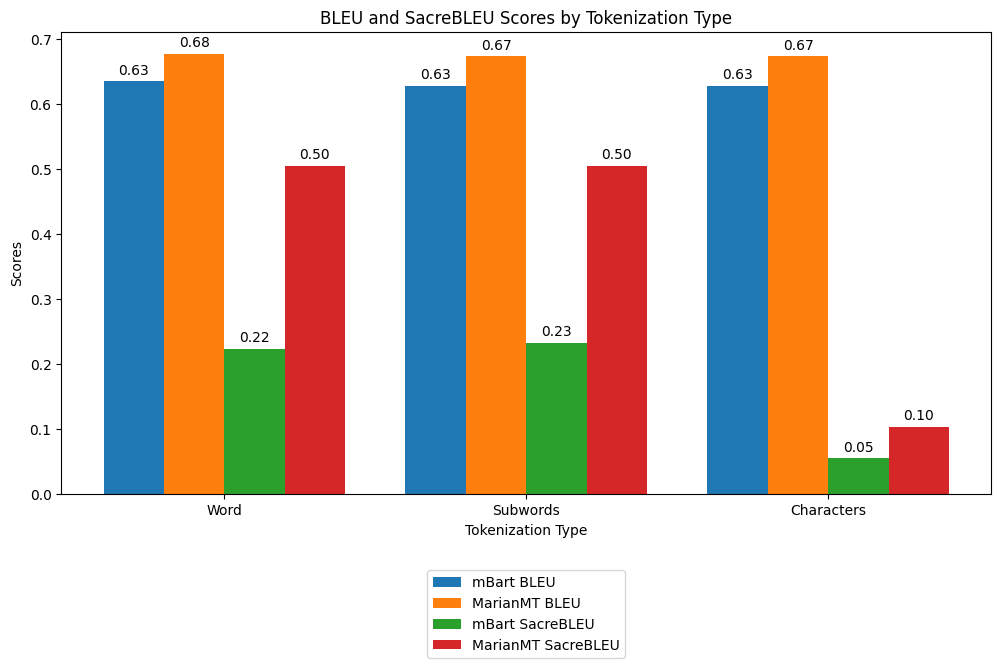

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual data)
tokenization_types = ["Word", "Subwords", "Characters"]

# Define the column names for each tokenization type
columns = {
    "Word": ["BLEU Score mBart", "BLEU Score MarianMT", "sacreBLEU Score mBart", "sacreBLEU Score MarianMT"],
    "Subwords": ["BLEU subwords mBart", "BLEU subwords MarianMT", "sacreBLEU subwords mBart", "sacreBLEU subwords MarianMT"],
    "Characters": ["BLEU characters mBart", "BLEU characters MarianMT", "sacreBLEU characters mBart", "sacreBLEU characters MarianMT"]
}

# Initialize lists to store the mean scores for each group
mbart_bleu_scores = []
marian_bleu_scores = []
mbart_sacrebleu_scores = []
marian_sacrebleu_scores = []

for tokenization_type in tokenization_types:
    columns_for_tokenization = columns[tokenization_type]

    # Calculate the mean scores for each column
    mbart_bleu = df_ref[columns_for_tokenization[0]].mean()
    marian_bleu = df_ref[columns_for_tokenization[1]].mean()
    mbart_sacrebleu = df_ref[columns_for_tokenization[2]].mean()
    marian_sacrebleu = df_ref[columns_for_tokenization[3]].mean()

    # Append the means to the respective lists
    mbart_bleu_scores.append(mbart_bleu)
    marian_bleu_scores.append(marian_bleu)
    mbart_sacrebleu_scores.append(mbart_sacrebleu)
    marian_sacrebleu_scores.append(marian_sacrebleu)

# Set the positions for the bars
x = np.arange(len(tokenization_types))
bar_width = 0.2

# Create grouped bar plots
plt.figure(figsize=(12, 6))

mbart_bars = plt.bar(x - 1.5 * bar_width, mbart_bleu_scores, bar_width, label="mBart BLEU", align="center")
marian_bars = plt.bar(x - 0.5 * bar_width, marian_bleu_scores, bar_width, label="MarianMT BLEU", align="center")
mbart_sacrebleu_bars = plt.bar(x + 0.5 * bar_width, mbart_sacrebleu_scores, bar_width, label="mBart SacreBLEU", align="center")
marian_sacrebleu_bars = plt.bar(x + 1.5 * bar_width, marian_sacrebleu_scores, bar_width, label="MarianMT SacreBLEU", align="center")

# Set labels and title
plt.xlabel("Tokenization Type")
plt.ylabel("Scores")
plt.title("BLEU and SacreBLEU Scores by Tokenization Type")
plt.xticks(x, tokenization_types)

# Add values on top of each bar
for bars in [mbart_bars, marian_bars, mbart_sacrebleu_bars, marian_sacrebleu_bars]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                     textcoords="offset points", ha='center', va='bottom')

# Move the legend down
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))

# Show the plot
plt.show()